## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### Library setting

In [28]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

### Camera calibration

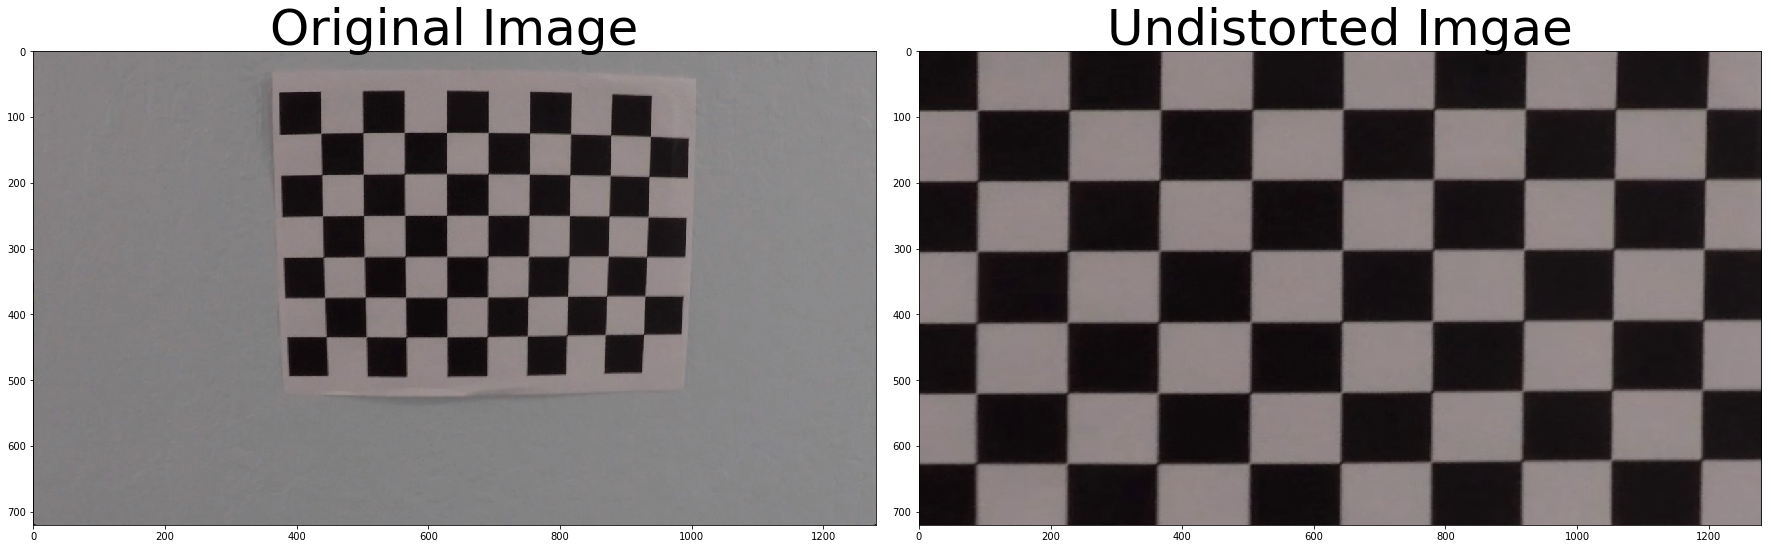

In [29]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    nx = 9
    ny = 6

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Undistort using mtx and dist
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,\
                                                      imgpoints, img.shape[1:], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        offset = 100 # offset for dst points
        img_size = (gray.shape[1], gray.shape[0])
        
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],\
                         [img_size[0]-offset, img_size[1]-offset],\
                         [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        
        warped = cv2.warpPerspective(undist, M, img_size)
        
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #cv2.imshow('img',img)
        #plt.imshow(img)
        #cv2.waitKey(500) 
        
#cv2.destroyAllWindows()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted Imgae', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [30]:
print('mtx:{}'.format(mtx))
print('dist:{}'.format(dist))

mtx:[[  1.15777920e+03   0.00000000e+00   6.67109905e+02]
 [  0.00000000e+00   1.15282308e+03   3.86127431e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist:[[-0.2469037  -0.02360439 -0.00109832  0.00035099 -0.00283723]]


### Color transforms, gradient, etc.

In [31]:
def mag_select(img, sobel_kernel=3, mag_thresh=(0,255)):
    # 1) Convert to grayscale
    gray_test_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray_test_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_test_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    
    # 4) Scale to 8-bit (0-255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def s_select(img, s_thresh=(0,255)):
    #1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #2) Apply a threshold to the S channel
    S = hls[:,:,2]
    
    #3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    return binary_output

def h_select(img, h_thresh=(0,255)):
    #1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #2) Apply a threshold to the H channel
    H = hls[:,:,0]
    
    #3) Return a binary image of threshold result
    binary_output = np.zeros_like(H)
    binary_output[(H > h_thresh[0]) & (H <= h_thresh[1])] = 1
    
    return binary_output

def threshold_pipeline(img, h_thresh=(18,100), s_thresh=(90,255),\
                      mag_thresh=(20,100)):
    # Magnitude 
    mag_binary = mag_select(img, sobel_kernel=3, mag_thresh=(20,100))
    #print('mag size:{}'.format(mag_binary.shape))
    
    # Saturation
    s_binary = s_select(img, s_thresh=(80,255))
    #print('s size:{}'.format(s_binary.shape))
        
    # Hue
    #h_binary = h_select(img, h_thresh=(20,100))
    #print('h size:{}'.format(h_binary.shape))
        
    # Stack each channel
    #result = np.dstack((np.zeros_like(mag_binary), mag_binary, s_binary))*255
    result = np.zeros_like(s_binary)
    result[(mag_binary == 1) | (s_binary == 1)] = 1
    
    return result

### Perspective transform func

In [32]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

### Lane finding func

In [33]:
def find_lane_pixels(binary_warped):
    # Step 1.split the histogram into two sides, one for each lane line.
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
 
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #print('win_y_low:{}'.format(win_y_low))
        #print('win_y_high:{}'.format(win_y_high))
        
        # Find the four below boundaries of the window #
        win_xleft_low = (leftx_current - margin)  # Update this
        win_xleft_high = (leftx_current + margin)  # Update this
        win_xright_low = (rightx_current - margin)  # Update this
        win_xright_high = (rightx_current + margin) # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window #
        # (`right` or `leftx_current`) on their mean position #
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [41]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +\
                        left_fit[2] - margin)) &\
                     (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +\
                        left_fit[2] + margin)))    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +\
                        right_fit[2] - margin)) &\
                     (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +\
                        right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fit, right_fit

### Curvature Calculation func

In [35]:
def measure_curvature_real(left_fit, right_fit, img):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0, 719, num=720)
    image_size = img.shape
    #print('image_size : {},{}'.format(image_size[0], image_size[1]))
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Implement the calculation of R_curve (radius of curvature) #
    left_1st_D = 2*left_fit[0]*y_eval + left_fit[1]
    left_2nd_D = np.abs(2*left_fit[0])
    left_curverad = np.sqrt(np.power((1+left_1st_D**2),3)) / (left_2nd_D)
    
    right_1st_D = 2*right_fit[0]*y_eval + right_fit[1]
    right_2nd_D = np.abs(2*right_fit[0])
    right_curverad = np.sqrt(np.power((1+right_1st_D**2),3)) / (right_2nd_D)
    
    # Average curvature
    avg_curvature = (left_curverad + right_curverad)/2
    
    # Vehicle Position
    bottom_y = img.shape[0]
    left_lane_x = left_fit[0]*bottom_y**2 + left_fit[1]*bottom_y + left_fit[2]
    right_lane_x = right_fit[0]*bottom_y**2 + right_fit[1]*bottom_y + right_fit[2]
    
    # Find lane center in pixel unit
    lane_center = (left_lane_x + right_lane_x)/2.
    offset_pixel = image_size[1]/2 - lane_center
    lane_offset_center_meter = offset_pixel*xm_per_pix
    
    
    return avg_curvature, lane_offset_center_meter

### Drawing Function

In [36]:
def visual_display(binary_warped, lf, rf, \
                   origin_img, src, dst):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Compute left_fitx and right_fitx
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    left_fitx = lf[0]*ploty**2 + lf[1]*ploty + lf[2]
    right_fitx = rf[0]*ploty**2 + rf[1]*ploty + rf[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    inverse_bird_view = warper(color_warp,dst, src)
    
    # Combine the result with the original image
    result = cv2.addWeighted(origin_img, 1, inverse_bird_view, 0.3, 0)
    
    return result

In [37]:
def plot_result(name_str, image):
    plt.imshow(image)
    plt.title(name_str)
    plt.show()

## Pipeline

In [42]:
def process_image(arg_image):
    
    # step 1. Apply a distortiong correction
    undist_image = cv2.undistort(arg_image, mtx, dist, None, mtx)
    
    # step 1. Create a thresholded binary image.
    binary_image = threshold_pipeline(undist_image)

    # step 2. Define FoV for warping.
    img_width, img_height = (binary_image.shape[1], binary_image.shape[0])
    src = np.float32([[(img_width/2) - 55, img_height/2 + 100],
                      [(img_width/6) - 10, img_height],
                      [(img_width*5/6) + 60, img_height],
                      [(img_width/2 + 55), img_height/2 + 100]
                     ])
    dst = np.float32([[(img_width/4), 0],
                      [(img_width/4), img_height],
                      [(img_width*3/4), img_height],
                      [(img_width*3/4), 0]])
    # step 2. Apply a perspective transform to "bird-eye view".
    warped_image = warper(binary_image, src, dst)
    
    # step 3. Detect lane pixels and fit to find the lane boundary.
    global sysCount
    global left_fit
    global right_fit
    if (sysCount == 0):
        leftx, lefty, rightx, righty = find_lane_pixels(warped_image)
        left_fit = np.polyfit(lefty, leftx,2)
        right_fit = np.polyfit(righty, rightx, 2)
        result_image, left_fit, right_fit = search_around_poly(warped_image, left_fit, right_fit)
        sysCount += 1
    else:
        result_image, left_fit, right_fit = search_around_poly(warped_image, left_fit, right_fit)
    
    # step 4. Deternmine the curvature of the lane,
    #         and vehicle position with respect to center.
    avg_curvature, lane_center_meter = measure_curvature_real(left_fit, right_fit, result_image)
    
    # step 5. Warp the detected lane boundaries back onto the origin image.
    final_result = visual_display(warped_image, left_fit, right_fit, undist_image, src, dst)
    
    # step 6. Display
    avg_curv_string = "Radius of Curvature: %.2f m" % avg_curvature
    lane_center_string = "Vehicle is %.2f m left of center" % lane_center_meter
    cv2. putText(final_result, avg_curv_string, (100,50), cv2.FONT_HERSHEY_PLAIN,\
                 4, (255,255,255), thickness=2)
    cv2. putText(final_result, lane_center_string, (100,100), cv2.FONT_HERSHEY_PLAIN,\
                 4, (255,255,255), thickness=2)
    
    #plot_output("Final Output", final_result)
    return final_result

### Pipeline Test for Image

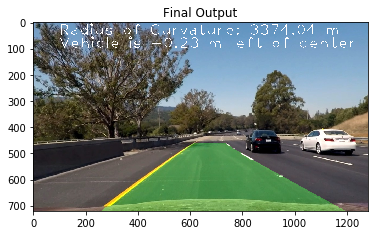

In [43]:
test_img = np.array(Image.open('test_images/test6.jpg'))

sysCount = 0

test_result = process_image(test_img)
plot_result("Final Output", test_result)

### Pipeline Test for Video

In [44]:
from moviepy.editor import VideoFileClip

project_video = 'project_video_processed.mp4'

sysCount = 0
left_fit = []
right_fit = []

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<02:53,  7.27it/s]



  0%|          | 2/1261 [00:00<03:18,  6.35it/s]



  0%|          | 3/1261 [00:00<03:21,  6.23it/s]



  0%|          | 4/1261 [00:00<03:14,  6.48it/s]



  0%|          | 5/1261 [00:00<03:06,  6.73it/s]



  0%|          | 6/1261 [00:00<03:01,  6.90it/s]



  1%|          | 7/1261 [00:01<02:58,  7.02it/s]



  1%|          | 8/1261 [00:01<02:59,  7.00it/s]



  1%|          | 9/1261 [00:01<02:57,  7.05it/s]



  1%|          | 10/1261 [00:01<02:56,  7.07it/s]



  1%|          | 11/1261 [00:01<02:54,  7.15it/s]



  1%|          | 12/1261 [00:01<02:54,  7.15it/s]



  1%|          | 13/1261 [00:01<02:53,  7.21it/s]



  1%|          | 14/1261 [00:02<02:53,  7.19it/s]



  1%|          | 15/1261 [00:02<02:52,  7.24it/s]



  1%|▏         | 16/1261 [00:02<02:54,  7.15it/s]



  1%|▏         | 17/1261 [00:02<02:52,  7.21it/s]



  1%|▏         | 18/1261 [00:02<02:54,  7.13it/s]



  2%|▏ 

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 2min 7s, sys: 28.8 s, total: 2min 36s
Wall time: 4min 47s
